In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM,Conv1D,MaxPooling1D,Dropout,Dense,Input,GlobalAveragePooling1D,Embedding
from keras.utils import to_categorical
from keras.models import Model
from keras import backend as K

%matplotlib inline

In [4]:
df=pd.read_csv('GrammarandProductReviews.csv')
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


(array([ 3701.,     0.,  1833.,     0.,     0.,  4369.,     0., 14598.,
            0., 46543.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

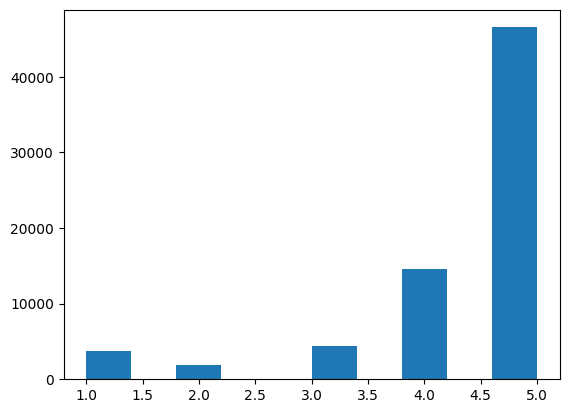

In [5]:
plt.hist(df['reviews.rating'])

In [6]:
df['target']=df['reviews.rating']<4

In [7]:
train_text,test_text,train_y,test_y=train_test_split(df['reviews.text'],df['target'],test_size=0.2)

In [8]:
train_text.shape

(56835,)

In [9]:
MAX_NB_WORDS=20000

texts_train=train_text.astype(str)
texts_test=test_text.astype(str)

tokenizer=Tokenizer(MAX_NB_WORDS,char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences=tokenizer.texts_to_sequences(texts_train)
sequences_test=tokenizer.texts_to_sequences(texts_test)

word_index=tokenizer.word_index
print('Found %s unique tokenks.' %len(word_index))

Found 26057 unique tokenks.


In [10]:
sequences[0]

[589,
 37,
 1,
 128,
 80,
 125,
 5,
 690,
 29,
 61,
 3,
 244,
 130,
 341,
 17,
 21,
 1,
 887,
 8,
 1286,
 919,
 58,
 527,
 200,
 130,
 273,
 41,
 1626,
 804,
 94,
 117,
 3,
 19,
 72,
 612,
 110,
 44,
 85,
 180,
 1082,
 108,
 29,
 319,
 112,
 68,
 402,
 88,
 489,
 2,
 44,
 211,
 30,
 6,
 18,
 767]

In [11]:
type(tokenizer.word_index),len(tokenizer.word_index)

(dict, 26057)

In [12]:
index_to_word=dict((i,w) for w,i in tokenizer.word_index.items())

In [13]:
" ".join([index_to_word[i] for i in sequences[0]])

"i'd like the old tide back it cleaned so well and left clothes smelling great but the addition of acti lift has changed everything clothes come out stiff rather than soft and with no pleasant scent just an off odor i'm so disappointed i've been trying other brands i just can't use this product anymore"

In [14]:
seq_lens=[len(s) for s in sequences]
print("average length: %0.1f" %np.mean(seq_lens))
print("max length: %d" %max(seq_lens))

average length: 39.4
max length: 1034


(array([2.2278e+04, 1.7528e+04, 7.2720e+03, 3.8210e+03, 2.2690e+03,
        1.2880e+03, 7.8800e+02, 5.1500e+02, 3.3100e+02, 2.2100e+02,
        1.4300e+02, 9.8000e+01, 6.8000e+01, 5.1000e+01, 3.7000e+01,
        2.3000e+01, 2.0000e+01, 1.5000e+01, 1.2000e+01, 1.1000e+01,
        1.3000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00,
        5.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   0.  ,   20.68,   41.36,   62.04,   82.72,  103.4 ,  124.08,
         144.76,  165.44,  186.12,  206.8 ,  227.48,  248.16,  268.84,
         289.52,  310.2 ,  330.88,  351.56,  372.24,  392.92,  413.6 ,
         434.28,  454.96,  475.64,  496.32,  517.  ,  537.68,  558.36,
         579.04,  599.72,  620.4 ,

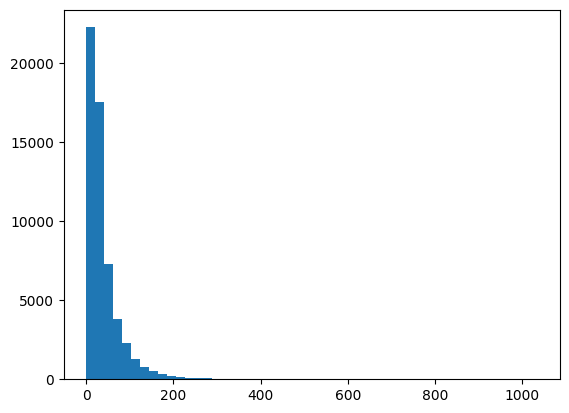

In [15]:
plt.hist(seq_lens,bins=50)

(array([ 672., 1091., 6020., 7481., 5544., 5334., 4157., 3312., 2832.,
        2335., 2001., 1715., 1474., 1257., 1109., 1015.,  916.,  784.,
         771.,  643.,  586.,  513.,  463.,  449.,  359.,  335.,  293.,
         263.,  242.,  238.,  213.,  181.,  160.,  155.,  170.,  133.,
         106.,  105.,  106.,   91.,   98.,   74.,   55.,   65.,   78.,
          59.,   46.,   51.,   42.,   38.]),
 array([  0.  ,   3.98,   7.96,  11.94,  15.92,  19.9 ,  23.88,  27.86,
         31.84,  35.82,  39.8 ,  43.78,  47.76,  51.74,  55.72,  59.7 ,
         63.68,  67.66,  71.64,  75.62,  79.6 ,  83.58,  87.56,  91.54,
         95.52,  99.5 , 103.48, 107.46, 111.44, 115.42, 119.4 , 123.38,
        127.36, 131.34, 135.32, 139.3 , 143.28, 147.26, 151.24, 155.22,
        159.2 , 163.18, 167.16, 171.14, 175.12, 179.1 , 183.08, 187.06,
        191.04, 195.02, 199.  ]),
 <BarContainer object of 50 artists>)

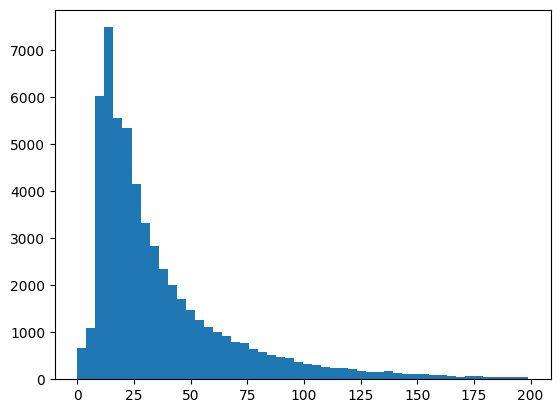

In [16]:
plt.hist([l for l in seq_lens if l<200],bins=50)

In [17]:
MAX_SEQUENCE_LENGTH=150

x_train=pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
x_test=pad_sequences(sequences_test,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ',x_train.shape)
print('Shape of data test tensor: ',x_test.shape)

Shape of data tensor:  (56835, 150)
Shape of data test tensor:  (14209, 150)


In [18]:
y_train=train_y
y_test=test_y

y_train=to_categorical(np.asarray(y_train))
print('Shape to label tensor: ',y_train.shape)

Shape to label tensor:  (56835, 2)


In [19]:
EMBEDDING_DIM=50
N_CLASSES=2

sequence_input=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedding_layer=Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH,trainable=True)
embedded_sequences=embedding_layer(sequence_input)

average=GlobalAveragePooling1D()(embedded_sequences)
predictions=Dense(N_CLASSES,activation='softmax')(average)

model=Model(sequence_input,predictions)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [20]:
model.fit(x_train,y_train,validation_split=0.1,epochs=10,batch_size=128)

Epoch 1/10
400/400 [==============================] - 7s 16ms/step - loss: 0.3986 - acc: 0.8618 - val_loss: 0.3611 - val_acc: 0.8624
Epoch 2/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3246 - acc: 0.8710 - val_loss: 0.3079 - val_acc: 0.8776
Epoch 3/10
400/400 [==============================] - 6s 15ms/step - loss: 0.2728 - acc: 0.8881 - val_loss: 0.2715 - val_acc: 0.8895
Epoch 4/10
400/400 [==============================] - 11s 28ms/step - loss: 0.2412 - acc: 0.9014 - val_loss: 0.2538 - val_acc: 0.8976
Epoch 5/10
400/400 [==============================] - 11s 29ms/step - loss: 0.2218 - acc: 0.9110 - val_loss: 0.2456 - val_acc: 0.9029
Epoch 6/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2086 - acc: 0.9170 - val_loss: 0.2391 - val_acc: 0.9064
Epoch 7/10
400/400 [==============================] - 7s 18ms/step - loss: 0.1983 - acc: 0.9224 - val_loss: 0.2369 - val_acc: 0.9094
Epoch 8/10
400/400 [==============================] - 6s 16ms/step 

In [21]:
output_test=model.predict(x_test)
print("test auc: ",roc_auc_score(y_test,output_test[:,1]))

445/445 [==============================] - 1s 2ms/step
test auc:  0.913174980360397


In [22]:
sequence_input=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedded_sequences=embedding_layer(sequence_input)

x=LSTM(128,dropout=0.2,recurrent_dropout=0.2)(embedded_sequences)
predictions=Dense(2,activation='softmax')(x)

model=Model(sequence_input,predictions)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
model.fit(x_train,y_train,validation_split=0.1,epochs=2,batch_size=128)

Epoch 1/2
131/400 [========>.....................] - ETA: 4:04 - loss: 0.2060 - acc: 0.9225

In [ ]:
output_test=model.predict(x_test)
print("test auc: ",roc_auc_score(y_test,output_test[:,1]))

In [ ]:
sequence_input=Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedded_sequences=embedding_layer(sequence_input)

x=Conv1D(64,5)(embedded_sequences)
x=MaxPooling1D(5)(x)
x=Dropout(0.2)(x)
x=Conv1D(64,5)(x)
x=MaxPooling1D(5)(x)
x=Dropout(0.2)(x)
x=LSTM(64)(x)
predictions=Dense(2,activation='softmax')(x)

model=Model(sequence_input,predictions)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
model.fit(x_train,y_train,validation_split=0.1,epochs=5,batch_size=128)

In [ ]:
output_test=model.predict(x_test)
print("test auc: ",roc_auc_score(y_test,output_test[:,1]))

In [ ]:
get_emb_layer_output=K.function([model.layers[0].input],[model.layers[2].input])
embedding_output=get_emb_layer_output([x_test[:3000]])[0]
emb_shape=embedding_output.shape
to_plot_embedding=embedding_output.reshape(emb_shape[0],emb_shape[1]*emb_shape[2])
y=y_test[:3000]

In [ ]:
sentence_emb_tsne=TSNE(perplexity=30).fit_transform(to_plot_embedding)
print(sentence_emb_tsne.shape)
print(y.shape)

In [ ]:
plt.figure()
plt.scatter(sentence_emb_tsne[np.where(y==0),0],sentence_emb_tsne[np.where(y==0),1],marker='x',color='g',linewidths=1,alpha=0.8,label='Happy')
plt.scatter(sentence_emb_tsne[np.where(y==1),0],sentence_emb_tsne[np.where(y==1),1],marker='v',color='r',linewidths=1,alpha=0.8,label='Unhappy')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE')
plt.legend(loc='best')
#plt.savefig('1.png')
plt.show()